In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

n = 1000

df = pd.DataFrame({
    'claim_amount': np.random.normal(25000, 10000, n).round(2),
    'injury_type': np.random.choice(['None', 'Minor', 'Major'], n, p=[0.5, 0.3, 0.2]),
    'repair_shop': np.random.choice(['Partnered', 'Non-Partnered'], n),
    'claim_delay': np.random.randint(1, 120, n),
    'vehicle_age': np.random.randint(0, 20, n),
    'num_previous_claims': np.random.randint(0, 5, n),
    'region': np.random.choice(['North', 'South', 'East', 'West'], n),
    'Label': np.random.choice(['Not Fraud', 'Fraud'], n, p=[0.9, 0.1])
})

df.to_csv("insurance_fraud_dataset.csv", index=False)
df.head()

,claim_amount,injury_type,repair_shop,claim_delay,vehicle_age,num_previous_claims,region,Label
0,29967.14,None,Non-Partnered,55,3,0,West,Not Fraud
1,23617.36,None,Non-Partnered,102,9,3,North,Not Fraud
2,31476.89,Minor,Partnered,118,4,3,North,Not Fraud
3,40230.30,Minor,Non-Partnered,82,9,2,South,Not Fraud
4,22658.47,None,Non-Partnered,26,11,2,West,Not Fraud


In [ ]:
df = pd.read_csv("insurance_fraud_dataset.csv")

df_encoded = pd.get_dummies(df, columns=['injury_type', 'repair_shop', 'region'], drop_first=True)

df_encoded['Label'] = df_encoded['Label'].map({'Not Fraud': 0, 'Fraud': 1})

X = df_encoded.drop('Label', axis=1)
y = df_encoded['Label']

for col in ['injury_type_Minor', 'repair_shop_Partnered', 'region_North', 'region_South', 'region_West']:
  if col in X.columns:
    X[col] = X[col].astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1, random_state=42)
y_pred_iso = iso.fit_predict(X)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

In [ ]:
!pip install -q xgboost shap

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [ ]:
import pandas as pd

df = pd.read_csv("insurance_fraud_dataset.csv")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

In [ ]:
from sklearn.metrics import classification_report

print("Random Forest:\n", classification_report(y_test, y_pred_rf, zero_division=1))

Random Forest:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       180
           1       1.00      0.00      0.00        20

    accuracy                           0.90       200
   macro avg       0.95      0.50      0.47       200
weighted avg       0.91      0.90      0.85       200



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop('Label', axis=1)
y = df['Label'].map({'Not Fraud': 0, 'Fraud': 1})

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_res, y_res)
y_pred_rf = rf.predict(X_test)

print("Random Forest with SMOTE:\n", classification_report(y_test, y_pred_rf, zero_division=1))

Random Forest with SMOTE:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       180
           1       0.00      0.00      0.00        20

    accuracy                           0.88       200
   macro avg       0.45      0.49      0.47       200
weighted avg       0.81      0.88      0.84       200



In [26]:
xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=9, random_state=42)

In [27]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df.drop('Label', axis=1)
y = df['Label'].map({'Not Fraud': 0, 'Fraud': 1})

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost with SMOTE:\n", classification_report(y_test, y_pred_xgb, zero_division=1))

XGBoost with SMOTE:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       180
           1       0.00      0.00      0.00        20

    accuracy                           0.88       200
   macro avg       0.45      0.49      0.47       200
weighted avg       0.81      0.88      0.84       200



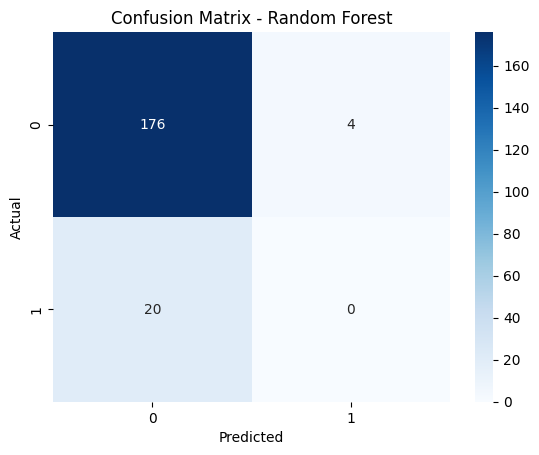

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

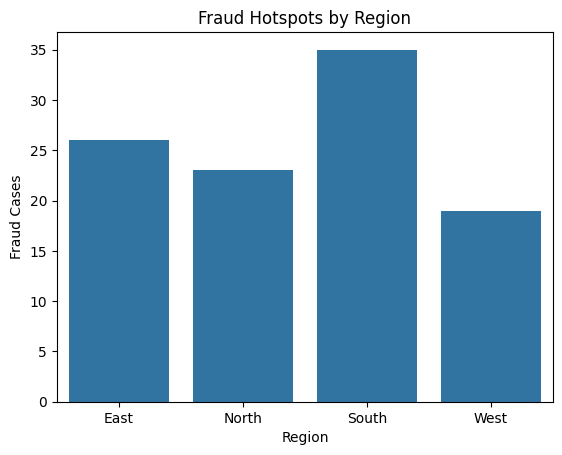

In [30]:
df_plot = df.copy()
df_plot['Label'] = df_plot['Label'].map({'Fraud': 1, 'Not Fraud': 0})
fraud_counts = df_plot.groupby('region')['Label'].sum().reset_index()

sns.barplot(data=fraud_counts, x='region', y='Label')
plt.title("Fraud Hotspots by Region")
plt.xlabel("Region")
plt.ylabel("Fraud Cases")
plt.show()